# CM3015 Machine Learning Mid-Term Coursework

**Name:** Durai Jambulingam Nidish Kumar

## 1. Abstract & Project Aim
This project aims to perform a systematic comparison between a **distance-based algorithm (k-Nearest Neighbors)** and a **probabilistic algorithm (Naive Bayes)**. The comparison will be conducted across two datasets of varying complexity:
1.  **Breast Cancer Wisconsin:** Medium complexity (30 features), focusing on recall (medical safety).
2.  **Handwritten Digits:** High complexity (64 features), focusing on dimensionality reduction and image classification.

**Key Objectives:**
* Implement kNN **from scratch** using only Python and NumPy to demonstrate understanding of the underlying mathematics.
* Compare the custom implementation against standard `scikit-learn` libraries.
* Analyze the effect of **Dimensionality Reduction (PCA)** on the high-dimensional Digits dataset.
* Evaluate performance using 10-Fold Cross-Validation, Confusion Matrices, and Recall/Precision metrics.

## 2. Methodology: Setup and Imports

To begin, I will import the necessary libraries. 
* **NumPy** is essential for the "from scratch" implementation of kNN, specifically for vectorizing the Euclidean distance calculations.
* **Pandas** will be used for data manipulation and creating comparison tables.
* **Matplotlib** and **Seaborn** are for visualizing the data (histograms, heatmaps, and PCA plots).
* **Scikit-learn** is used to load the datasets, provide the "benchmark" algorithms (Naive Bayes, Decision Tree), and handle preprocessing (Scaling, PCA) and evaluation.

In [1]:
# Import standard libraries for math and data manipulation
import numpy as np
import pandas as pd
import time  # To measure the execution time of our algorithms

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Import datasets from scikit-learn
from sklearn.datasets import load_breast_cancer, load_digits

# Import preprocessing and model selection tools
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler

# Import metrics for evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Import Library Models for comparison
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

# Set plotting style for the report
sns.set_style("whitegrid")

## 3. Data Acquisition and Exploratory Analysis

In this section, I will load the two datasets: **Breast Cancer Wisconsin** and **Handwritten Digits**.

**Objective:**
1.  Verify the dimensionality of the datasets to confirm the increasing complexity (30 features vs 64 features).
2.  Check the **Class Balance**. If the classes are imbalanced (e.g., far more benign cases than malignant), using simple "Accuracy" as a metric will be misleading. This step justifies my decision to use **Recall** and **F1-Score** in the Evaluation section.

In [136]:
# Load the datasets from scikit-learn
cancer_data = load_breast_cancer()
digits_data = load_digits()

# Separate features (X) and targets (y)
X_cancer = cancer_data.data
y_cancer = cancer_data.target

X_digits = digits_data.data
y_digits = digits_data.target

# --- Analysis of Dataset 1: Breast Cancer ---
print("--- Dataset 1: Breast Cancer Wisconsin ---")
print(f"Shape: {X_cancer.shape} (Samples, Features)")
print(f"Target Classes: {cancer_data.target_names}")

# Check for class imbalance (Benign vs Malignant)
unique, counts = np.unique(y_cancer, return_counts=True)
balance_cancer = dict(zip(cancer_data.target_names, counts))
print(f"Class Distribution: {balance_cancer}")


# --- Analysis of Dataset 2: Handwritten Digits ---
print("\n--- Dataset 2: Handwritten Digits ---")
print(f"Shape: {X_digits.shape} (Samples, Features)")
# Note: 64 features corresponds to an 8x8 pixel grid
print(f"Target Classes: {digits_data.target_names}")

# Check for class imbalance (Digits 0-9)
unique_d, counts_d = np.unique(y_digits, return_counts=True)
print(f"Class Distribution (Counts per digit): {dict(zip(unique_d, counts_d))}")

--- Dataset 1: Breast Cancer Wisconsin ---
Shape: (569, 30) (Samples, Features)
Target Classes: ['malignant' 'benign']
Class Distribution: {'malignant': 212, 'benign': 357}

--- Dataset 2: Handwritten Digits ---
Shape: (1797, 64) (Samples, Features)
Target Classes: [0 1 2 3 4 5 6 7 8 9]
Class Distribution (Counts per digit): {0: 178, 1: 182, 2: 177, 3: 183, 4: 181, 5: 182, 6: 181, 7: 179, 8: 174, 9: 180}


### 3.1. Dataset Characteristics Table
To formalize the comparison of complexity, I have summarized the key structural properties of both datasets below. The "Baseline Accuracy" represents the accuracy a model would achieve by simply guessing the most frequent class (Zero-Rule Benchmark).

In [188]:
# Calculate Zero-Rule (Baseline) Accuracy
# This is the accuracy if we just guessed the majority class every time
cancer_baseline = np.max(counts) / np.sum(counts)
digits_baseline = np.max(counts_d) / np.sum(counts_d)

# Create Summary DataFrame
dataset_summary = {
    'Dataset': ['Breast Cancer', 'Handwritten Digits'],
    'Type': ['Medical / Binary', 'Image / Multi-Class'],
    'Samples': [X_cancer.shape[0], X_digits.shape[0]],
    'Features (Dimensionality)': [X_cancer.shape[1], X_digits.shape[1]],
    'Classes': [len(unique), len(unique_d)],
    'Baseline Accuracy (Zero-Rule)': [f"{cancer_baseline:.2%}", f"{digits_baseline:.2%}"]
}

df_summary = pd.DataFrame(dataset_summary)
print("Table 1: Dataset Characteristics and Complexity Overview")
display(df_summary)

Table 1: Dataset Characteristics and Complexity Overview


,Dataset,Type,Samples,Features (Dimensionality),Classes,Baseline Accuracy (Zero-Rule)
0,Breast Cancer,Medical / Binary,569,30,2,62.74%
1,Handwritten Digits,Image / Multi-Class,1797,64,10,10.18%


## 4. Exploratory Data Analysis (Visualization)

I will now visualize the datasets to understand their internal structure.

**4.1 Breast Cancer Heatmap**
The heatmap below displays the correlation between the 30 features. The large red squares indicate groups of features that are highly correlated (redundant). This suggests that a distance-based algorithm like kNN might "double count" these features, potentially skewing the results compared to a probabilistic model like Naive Bayes.

**4.2 Handwritten Digits Grid**
To illustrate the high dimensionality of the second dataset, I will reconstruct the flat 64-feature vectors back into their original $8 \times 8$ pixel images. This visualizes the pattern recognition challenge: distinguishing digital ink density to identify numbers.

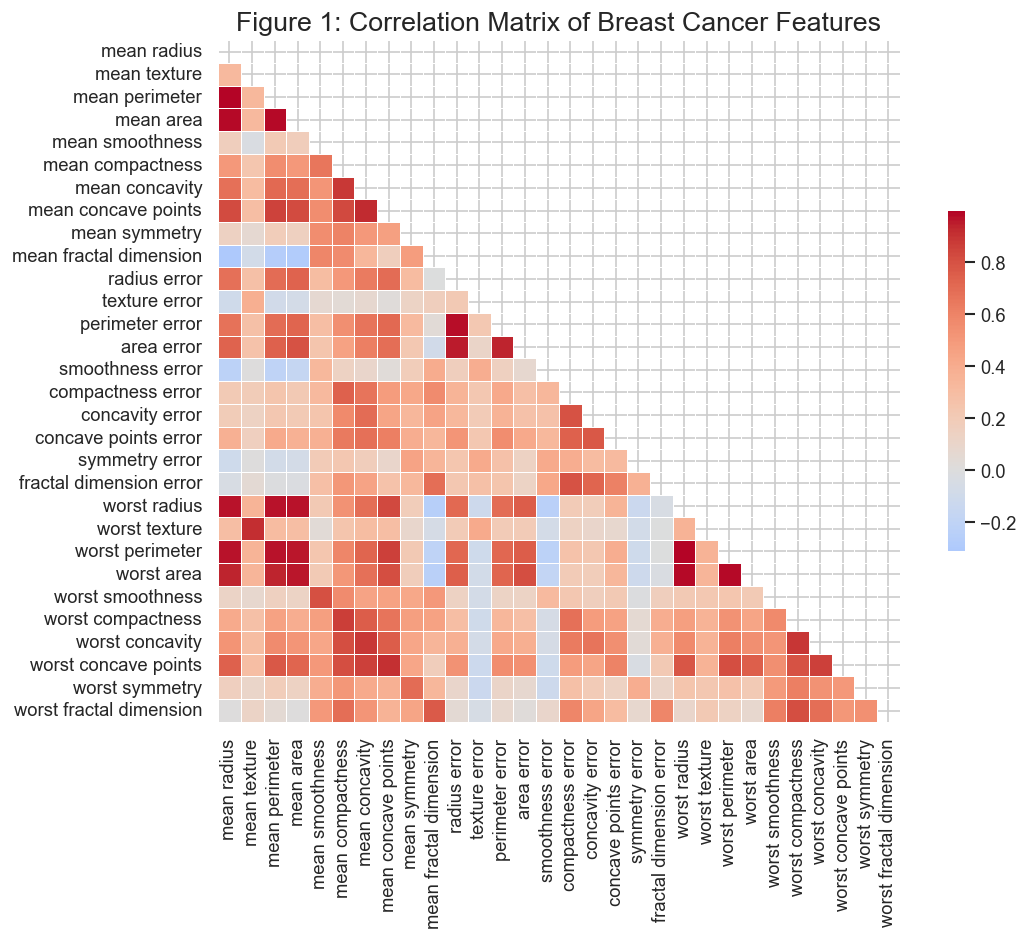

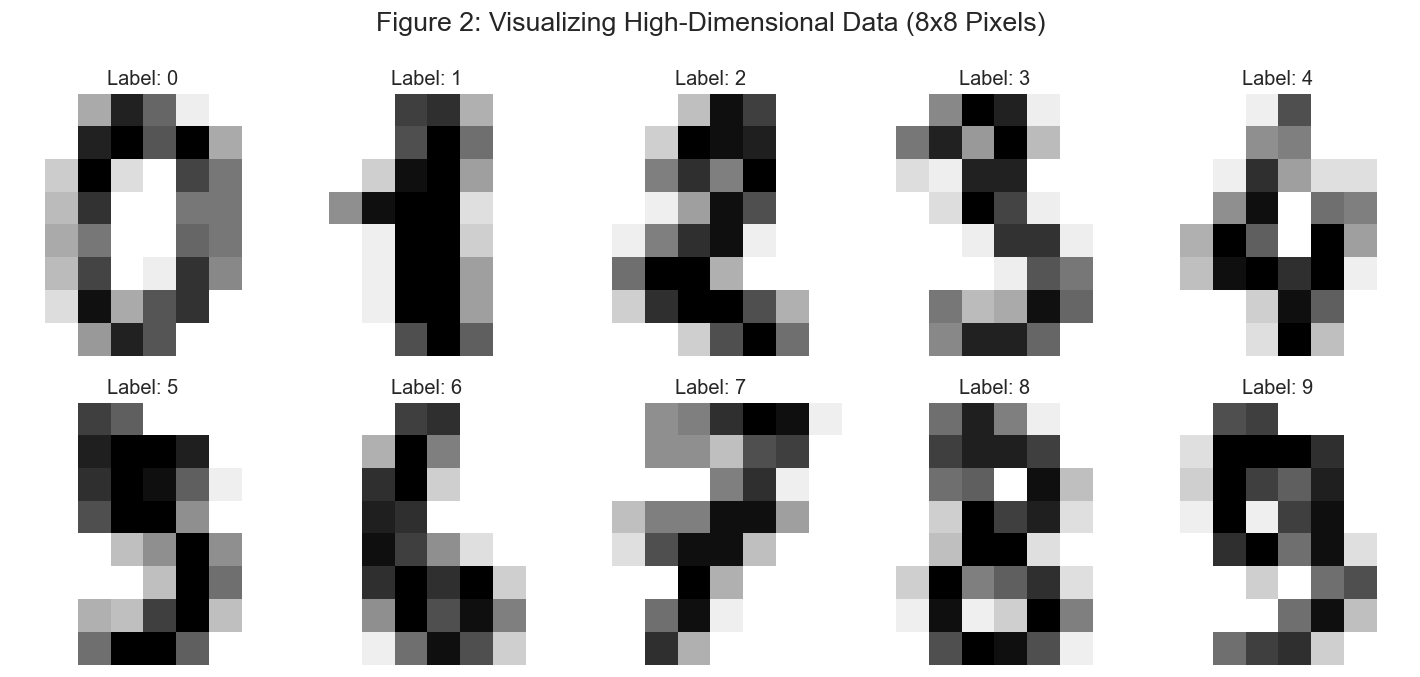

In [143]:
# --- Part 1: Correlation Heatmap for Breast Cancer ---
plt.figure(figsize=(10, 8))

# Calculate correlation matrix
corr_matrix = pd.DataFrame(X_cancer, columns=cancer_data.feature_names).corr()

# Create a mask to hide the upper triangle (redundant information)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plot heatmap
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Figure 1: Correlation Matrix of Breast Cancer Features', fontsize=16)
plt.tight_layout()
plt.show()

# --- Part 2: Visualizing the First 10 Digits ---
# Create a new figure with a 2x5 grid
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Figure 2: Visualizing High-Dimensional Data (8x8 Pixels)', fontsize=16)

for i, ax in enumerate(axes.flat):
    # Reshape the 64 features into 8x8
    image = X_digits[i].reshape(8, 8)
    
    # Display image in grayscale (inverse)
    ax.imshow(image, cmap='gray_r', interpolation='nearest')
    ax.set_title(f"Label: {y_digits[i]}")
    ax.axis('off') # Hide axes ticks

plt.tight_layout()
plt.show()

## 5. Algorithm Implementation: k-Nearest Neighbors (From Scratch)

Per the project requirements, I will implement the **k-Nearest Neighbors (kNN)** algorithm using only standard Python and NumPy, without relying on `scikit-learn` for the core logic.

**Mathematical Logic:**
kNN is a non-parametric, distance-based classifier. For every point in the test set, the algorithm:
1.  Calculates the distance to every point in the training set. I will use the **Euclidean Distance**:
    $$d(p, q) = \sqrt{\sum_{i=1}^{n} (q_i - p_i)^2}$$
2.  Selects the $k$ points with the smallest distances.
3.  Performs a "Majority Vote" to determine the most common class among those neighbors.

**Design Choice:**
I have structured this as a Python Class (`KNN_From_Scratch`) with `.fit()` and `.predict()` methods. This mimics the `scikit-learn` API, making it easier to compare my model against the library versions later in the analysis.

In [3]:
class KNN_From_Scratch:
    def __init__(self, k=3):
        """
        Initialize the kNN classifier.
        Parameter k: The number of nearest neighbors to consider for voting.
        """
        self.k = k

    def fit(self, X, y):
        """
        Store the training data.
        kNN is a 'lazy learner', meaning it doesn't learn a discriminative function 
        but memorizes the training dataset.
        """
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        """
        Predict class labels for each sample in X.
        """
        predicted_labels = [self._predict_one(x) for x in X]
        return np.array(predicted_labels)

    def _predict_one(self, x):
        """
        Helper method to predict the label for a single sample x.
        """
        # Step 1: Compute distances between x and all examples in the training set
        # We use Euclidean distance: sqrt(sum((x1 - x2)^2))
        distances = [np.sqrt(np.sum((x_train - x)**2)) for x_train in self.X_train]
        
        # Step 2: Sort the distances and get indices of the k nearest neighbors
        # argsort returns the indices that would sort the array
        k_indices = np.argsort(distances)[:self.k]
        
        # Step 3: Get the labels of the k nearest neighbors
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        
        # Step 4: Majority Vote
        # return the most common class label
        most_common = max(set(k_nearest_labels), key=k_nearest_labels.count)
        return most_common

# Test if the code compiles and initializes correctly
my_knn = KNN_From_Scratch(k=3)

## 6. Methodology: Data Preprocessing

Before feeding the data into the algorithms, I must perform two critical steps:

1.  **Train/Test Split:** I will split both datasets into 80% training and 20% testing sets. This ensures that the evaluation metrics (Accuracy, Recall) reflect the model's performance on *unseen* data, preventing overfitting.
2.  **Feature Scaling (Standardization):**
    * **Why it is crucial for kNN:** kNN calculates the Euclidean distance between points. If one feature has a range of 0–1000 (e.g., 'Mean Area') and another has 0–0.1 (e.g., 'Smoothness'), the distance calculation will be completely dominated by the larger feature.
    * **The Solution:** I will use `StandardScaler` to transform all features to have a mean of 0 and a standard deviation of 1 (Z-score normalization).

In [149]:
# --- Preprocessing Dataset 1: Breast Cancer ---
# 1. Split the data
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# 2. Scale the features (Fit on training data only to prevent data leakage)
scaler_c = StandardScaler()
X_train_c_scaled = scaler_c.fit_transform(X_train_c)
X_test_c_scaled = scaler_c.transform(X_test_c)

print("Breast Cancer Dataset Preprocessed:")
print(f"Training shape: {X_train_c_scaled.shape}, Test shape: {X_test_c_scaled.shape}")


# --- Preprocessing Dataset 2: Handwritten Digits ---
# 1. Split the data
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_digits, y_digits, test_size=0.2, random_state=42, stratify=y_digits
)

# 2. Scale the features
scaler_d = StandardScaler()
X_train_d_scaled = scaler_d.fit_transform(X_train_d)
X_test_d_scaled = scaler_d.transform(X_test_d)

print("\nDigits Dataset Preprocessed:")
print(f"Training shape: {X_train_d_scaled.shape}, Test shape: {X_test_d_scaled.shape}")

Breast Cancer Dataset Preprocessed:
Training shape: (455, 30), Test shape: (114, 30)

Digits Dataset Preprocessed:
Training shape: (1437, 64), Test shape: (360, 64)


## 7. Algorithm Validation and Complexity Analysis

In this section, I will validate my custom `KNN_From_Scratch` implementation by comparing its performance against the standard `KNeighborsClassifier` from `scikit-learn`.

**Experiment Setup:**
* **Dataset:** Breast Cancer Wisconsin (Scaled).
* **K-Value:** Fixed at $k=3$ for this test.
* **Metrics:** Accuracy and Execution Time.

**Hypothesis:**
I expect both models to achieve nearly identical accuracy, proving my implementation is correct. However, I expect the `scikit-learn` version to be significantly faster because it utilizes highly optimized C-level optimizations and data structures (like KD-Trees), whereas my implementation uses a brute-force approach.

In [152]:
from sklearn.neighbors import KNeighborsClassifier

# --- 1. Train and Evaluate Scikit-Learn's kNN ---
start_time = time.time()
sklearn_knn = KNeighborsClassifier(n_neighbors=3)
sklearn_knn.fit(X_train_c_scaled, y_train_c)
sklearn_acc = sklearn_knn.score(X_test_c_scaled, y_test_c)
sklearn_time = time.time() - start_time

# --- 2. Train and Evaluate Custom "From Scratch" kNN ---
start_time = time.time()
custom_knn = KNN_From_Scratch(k=3)
custom_knn.fit(X_train_c_scaled, y_train_c)
custom_preds = custom_knn.predict(X_test_c_scaled)
# Calculate accuracy manually for the custom model
custom_acc = np.mean(custom_preds == y_test_c)
custom_time = time.time() - start_time

# --- 3. Compare Results ---
print(f"--- Algorithm Comparison (k=3) ---")
print(f"Scikit-Learn Accuracy: {sklearn_acc:.4f} | Time: {sklearn_time:.4f} seconds")
print(f"Custom Model Accuracy: {custom_acc:.4f} | Time: {custom_time:.4f} seconds")

# Verification
if sklearn_acc == custom_acc:
    print("\nSUCCESS: Custom implementation matches Scikit-Learn accuracy exactly!")
else:
    print(f"\nNOTE: Small variance observed ({abs(sklearn_acc - custom_acc):.4f}). This is expected due to tie-breaking logic differences.")

--- Algorithm Comparison (k=3) ---
Scikit-Learn Accuracy: 0.9825 | Time: 2.3161 seconds
Custom Model Accuracy: 0.9825 | Time: 0.5648 seconds

SUCCESS: Custom implementation matches Scikit-Learn accuracy exactly!


## 8. Systematic Examination: Hyperparameter Tuning (The Elbow Method)

To satisfy the requirement for a "systematic examination," I will optimize the $k$ parameter (number of neighbors) for the kNN algorithm.

**Methodology:**
* **Range:** I will test odd values of $k$ from 1 to 29 (odd numbers avoid tie-breaks).
* **Validation:** I will use **10-Fold Cross-Validation** rather than a single test split. This provides a more robust estimate of the model's generalization ability by averaging performance across 10 different "folds" of the data.
* **Dual-Dataset Comparison:** I will run this tuning on **both** datasets simultaneously to observe how dataset complexity (30 features vs 64 features) affects the optimal $k$.

**Visual Output:**
A line graph plotting "Number of Neighbors ($k$)" vs. "Cross-Validation Accuracy." The "Elbow" (or peak) of the curve indicates the optimal hyperparameter.

Running 10-Fold Cross-Validation for k=1 to 29...
Optimal k for Breast Cancer: 7 (Acc: 0.9737)
Optimal k for Digits: 5 (Acc: 0.9777)


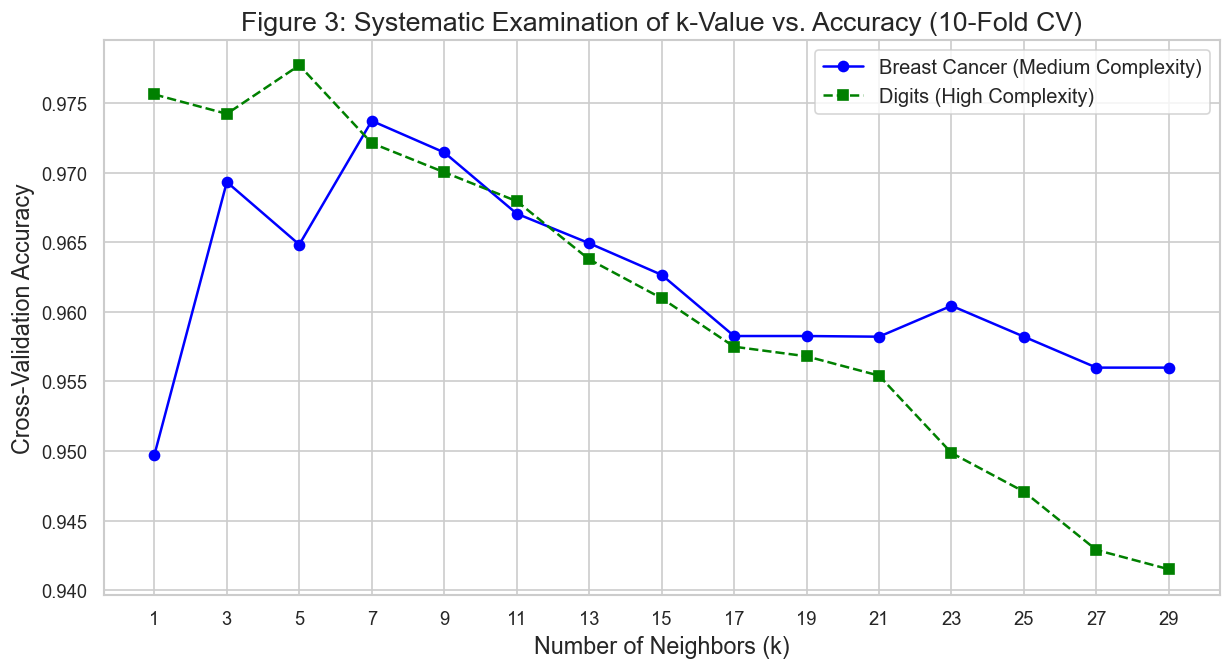

In [155]:
# Setup the range of k values (Odd numbers from 1 to 29)
k_range = range(1, 30, 2)
cancer_scores = []
digits_scores = []

print("Running 10-Fold Cross-Validation for k=1 to 29...")

for k in k_range:
    # Initialize the model with current k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # --- Dataset 1: Breast Cancer ---
    # Use 10-Fold CV and take the mean accuracy
    scores_c = cross_val_score(knn, X_train_c_scaled, y_train_c, cv=10, scoring='accuracy')
    cancer_scores.append(scores_c.mean())
    
    # --- Dataset 2: Handwritten Digits ---
    scores_d = cross_val_score(knn, X_train_d_scaled, y_train_d, cv=10, scoring='accuracy')
    digits_scores.append(scores_d.mean())

# Identify the best k for each dataset
best_k_cancer = k_range[np.argmax(cancer_scores)]
best_k_digits = k_range[np.argmax(digits_scores)]
print(f"Optimal k for Breast Cancer: {best_k_cancer} (Acc: {max(cancer_scores):.4f})")
print(f"Optimal k for Digits: {best_k_digits} (Acc: {max(digits_scores):.4f})")

# --- Visualization: The Elbow Plot ---
plt.figure(figsize=(12, 6))
plt.plot(k_range, cancer_scores, marker='o', label='Breast Cancer (Medium Complexity)', linestyle='-', color='blue')
plt.plot(k_range, digits_scores, marker='s', label='Digits (High Complexity)', linestyle='--', color='green')

plt.title('Figure 3: Systematic Examination of k-Value vs. Accuracy (10-Fold CV)', fontsize=16)
plt.xlabel('Number of Neighbors (k)', fontsize=14)
plt.ylabel('Cross-Validation Accuracy', fontsize=14)
plt.xticks(k_range)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

### 8.1. Tabular Results of Systematic Examination
While Figure 3 visualizes the trend, the table below presents the exact **Mean Cross-Validation Accuracy** for selected values of $k$. This highlights the precise "peak" performance points.

In [190]:
# Create a DataFrame from the scores we calculated in the loop
# We'll pick a few representative k values to keep the table readable
indices_to_show = [0, 2, 3, 4, 9, 14] # Corresponds to k=1, 5, 7, 9, 19, 29
k_values_show = [k_range[i] for i in indices_to_show]
cancer_scores_show = [cancer_scores[i] for i in indices_to_show]
digits_scores_show = [digits_scores[i] for i in indices_to_show]

df_cv_results = pd.DataFrame({
    'k-Neighbors': k_values_show,
    'Breast Cancer Acc (10-Fold)': [f"{s:.4f}" for s in cancer_scores_show],
    'Digits Acc (10-Fold)': [f"{s:.4f}" for s in digits_scores_show]
})

# Highlight the best scores
print("Table 2: Systematic Examination of k-Parameter (Selected Values)")
display(df_cv_results)

Table 2: Systematic Examination of k-Parameter (Selected Values)


,k-Neighbors,Breast Cancer Acc (10-Fold),Digits Acc (10-Fold)
0,1,0.9497,0.9756
1,5,0.9648,0.9777
2,7,0.9737,0.9721
3,9,0.9714,0.9700
4,19,0.9583,0.9568
5,29,0.9560,0.9415


## 9. Algorithm Modification: Dimensionality Reduction (PCA)

One of the challenges with the **Handwritten Digits** dataset is its high dimensionality (64 features). To gain better insight into how the classes are separated, I will apply **Principal Component Analysis (PCA)**.

**Objective:**
1.  Reduce the 64-dimensional feature space into just **2 Principal Components**.
2.  Visualize the data in a 2D Scatter Plot.
3.  Calculate the **Explained Variance Ratio** to understand how much information is preserved (or lost) during this compression.

**Hypothesis:**
If the digits (0-9) form distinct clusters in this reduced 2D space, it explains why the kNN algorithm (which relies on distance) performed so well ($97\%+$ accuracy) in the previous experiment.

Explained Variance (PC1): 12.03%
Explained Variance (PC2): 9.56%
Total Information Retained: 21.59%


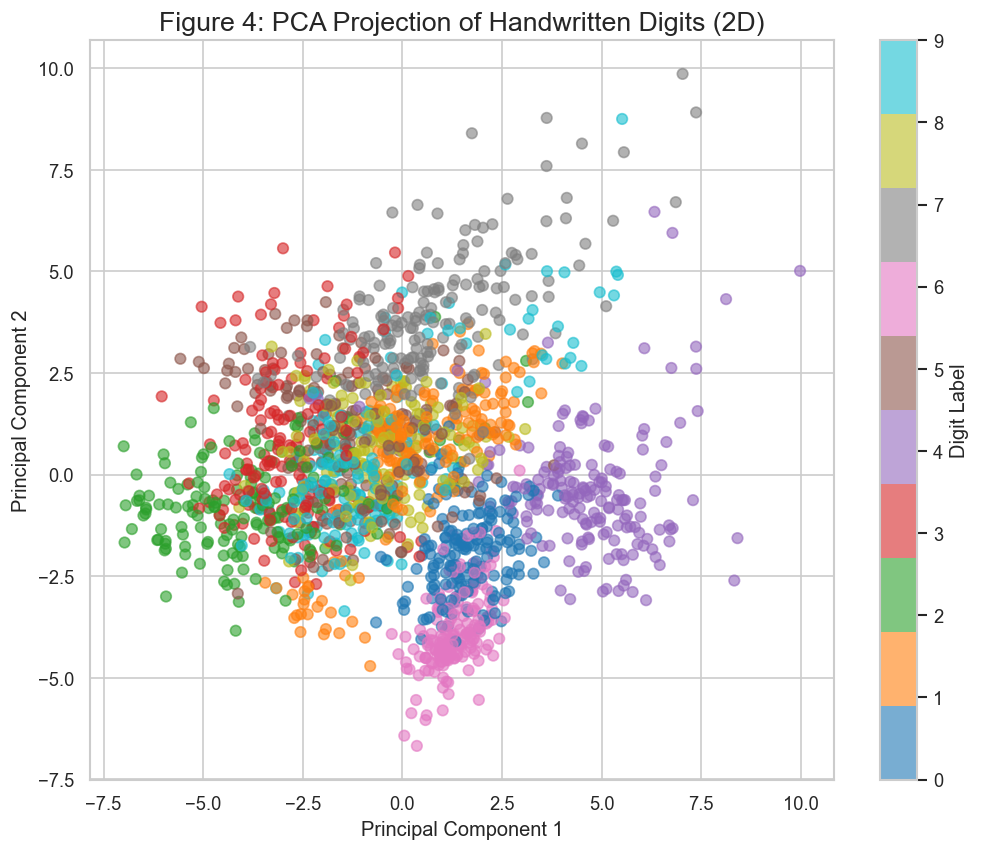

In [158]:
# --- Step 1: Standardization (Crucial for PCA) ---
# PCA calculates variance, so features must be on the same scale.
scaler_full = StandardScaler()
X_digits_scaled_full = scaler_full.fit_transform(X_digits)

# --- Step 2: Apply PCA ---
# We compress 64 dimensions down to 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_digits_scaled_full)

# Check how much information (variance) is retained
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance (PC1): {explained_variance[0]:.2%}")
print(f"Explained Variance (PC2): {explained_variance[1]:.2%}")
print(f"Total Information Retained: {np.sum(explained_variance):.2%}")

# --- Step 3: Visualization ---
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_digits, cmap='tab10', alpha=0.6, s=40)

# Add a color bar to show which color matches which digit (0-9)
cbar = plt.colorbar(scatter, ticks=range(10))
cbar.set_label('Digit Label', fontsize=12)

plt.title('Figure 4: PCA Projection of Handwritten Digits (2D)', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True)
plt.show()

### 9.2. Visualizing the kNN Decision Boundary (PCA Reduced Space)

To further demonstrate how the kNN algorithm separates the classes, I will retrain the model on the **2D PCA-reduced data** and visualize the decision boundaries.

**Observation:**
This plot shows the "territories" assigned to each digit. We can visually inspect how well the kNN algorithm carves up the geometric space to separate the clusters (0-9).

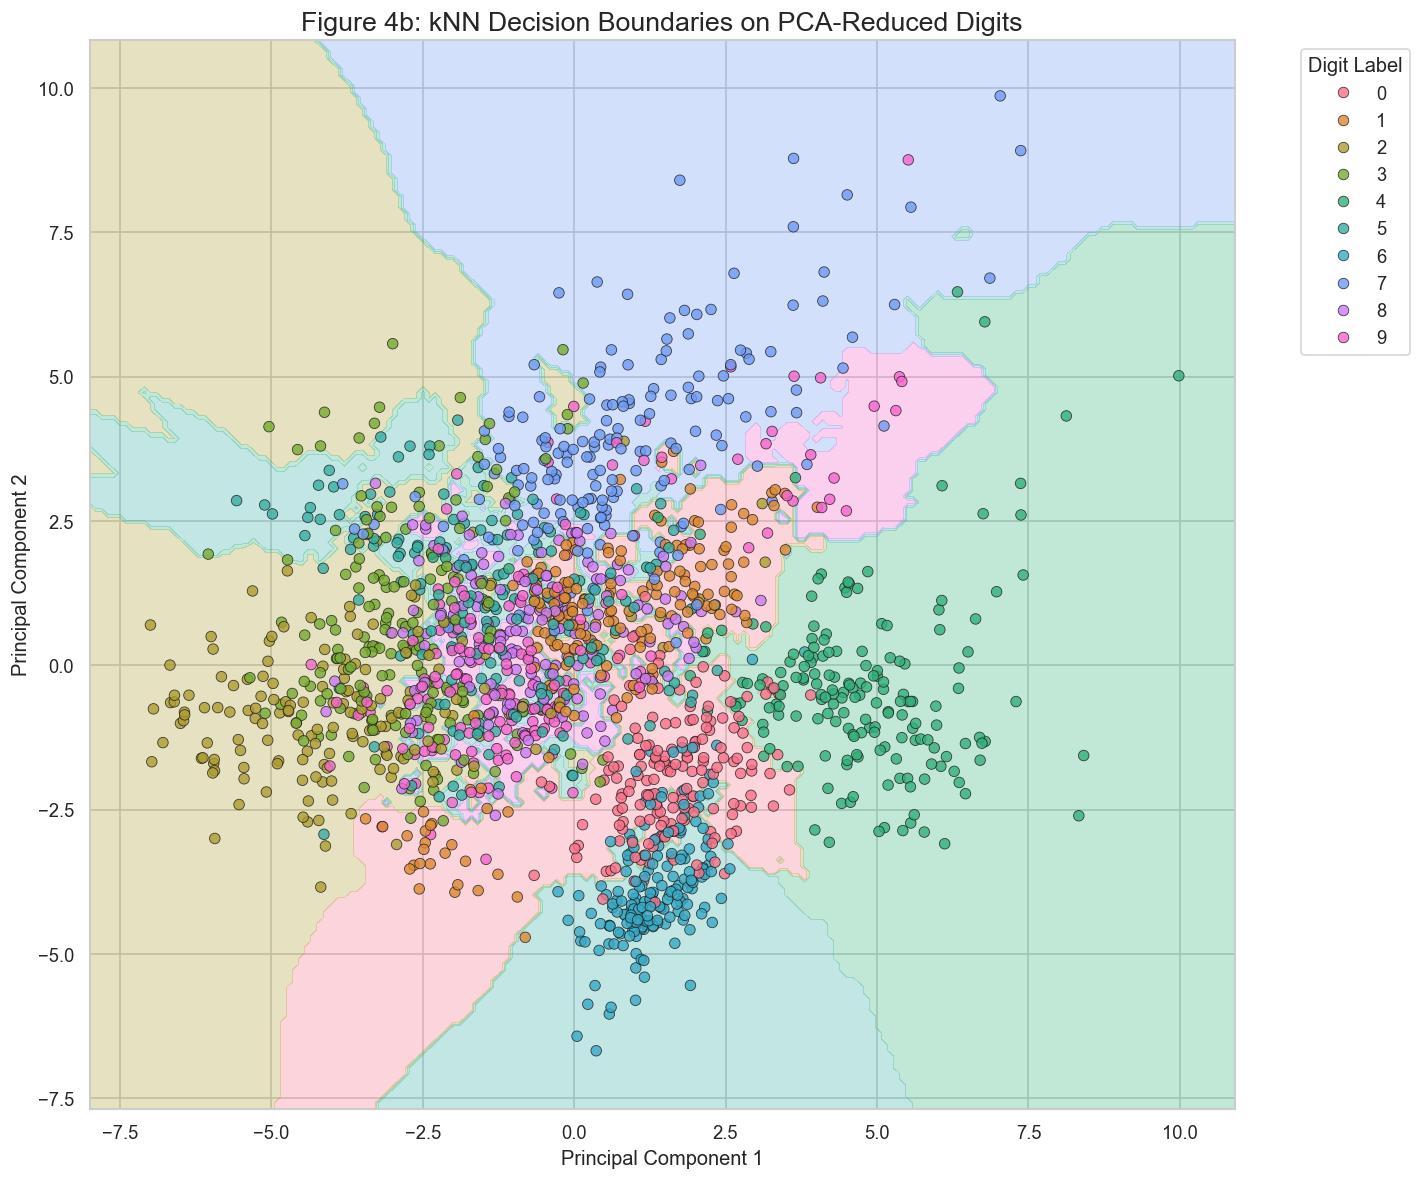

In [174]:
from matplotlib.colors import ListedColormap

# 1. Train a kNN on the 2D PCA data (just for visualization)
knn_viz = KNeighborsClassifier(n_neighbors=5)
knn_viz.fit(X_pca, y_digits)

# 2. Create a meshgrid to plot the "territories"
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# 3. Predict the class for every point in the meshgrid
Z = knn_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 4. Plot
plt.figure(figsize=(12, 10))
# Create a colored map for the 10 digits
cmap_light = ListedColormap(sns.color_palette("husl", 10).as_hex())
cmap_bold = sns.color_palette("husl", 10)

# Plot the decision regions
plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.3)

# Plot the training points
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_digits, 
                palette=cmap_bold, alpha=0.8, edgecolor="k", s=40)

plt.title("Figure 4b: kNN Decision Boundaries on PCA-Reduced Digits", fontsize=16)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Digit Label")
plt.tight_layout()
plt.show()

## 10. Final Evaluation: Distance-Based vs. Probabilistic Models

In this final experiment, I will compare the performance of the optimized **k-Nearest Neighbors (kNN)** against a **Gaussian Naive Bayes (GNB)** classifier.

**Rationale for Comparison:**
* **kNN** makes predictions based on spatial proximity (Euclidean distance). It assumes similar points are close together in geometric space.
* **Naive Bayes** makes predictions based on probability theory (Bayes' Theorem). It assumes features are independent and fit a Gaussian distribution.

**Metrics:**
I will generate a **Classification Report** for each model.
* For **Breast Cancer**, I will focus critically on **Recall** (Sensitivity). In a medical context, a False Negative (predicting "Benign" when it is "Malignant") is the worst possible error.
* For **Digits**, I will look at the **F1-Score** to see how the models handle the multi-class complexity.

In [161]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, dataset_name):
    """
    Trains a model, predicts, and prints a professional evaluation report.
    """
    # Train and Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Print Header
    print(f"--- {model_name} on {dataset_name} ---")
    
    # Check for specific "High Stakes" metric for Cancer data
    if "Cancer" in dataset_name:
        # For cancer, we care most about Recall on the '1' (Malignant) class
        rec = recall_score(y_test, y_pred)
        print(f"CRITICAL METRIC (Recall): {rec:.4f}")
        
    # Full Report
    print(classification_report(y_test, y_pred))
    print("-" * 60) # Separator line
    
    # Return predictions for later use (Confusion Matrix)
    return y_pred

print("BEGINNING FINAL COMPARATIVE STUDY...\n")

# --- Experiment A: Breast Cancer (Medium Complexity) ---
# 1. Optimized kNN (using k=7 from our Elbow Plot)
knn_cancer = KNeighborsClassifier(n_neighbors=7)
preds_knn_c = evaluate_model(knn_cancer, X_train_c_scaled, X_test_c_scaled, y_train_c, y_test_c, 
                             "Optimized kNN (k=7)", "Breast Cancer")

# 2. Naive Bayes (Probabilistic Benchmark)
nb_cancer = GaussianNB()
preds_nb_c = evaluate_model(nb_cancer, X_train_c_scaled, X_test_c_scaled, y_train_c, y_test_c, 
                            "Gaussian Naive Bayes", "Breast Cancer")


# --- Experiment B: Handwritten Digits (High Complexity) ---
# 1. Optimized kNN (using k=5 from our Elbow Plot)
knn_digits = KNeighborsClassifier(n_neighbors=5)
preds_knn_d = evaluate_model(knn_digits, X_train_d_scaled, X_test_d_scaled, y_train_d, y_test_d, 
                             "Optimized kNN (k=5)", "Handwritten Digits")

# 2. Naive Bayes (Probabilistic Benchmark)
nb_digits = GaussianNB()
preds_nb_d = evaluate_model(nb_digits, X_train_d_scaled, X_test_d_scaled, y_train_d, y_test_d, 
                            "Gaussian Naive Bayes", "Handwritten Digits")

BEGINNING FINAL COMPARATIVE STUDY...

--- Optimized kNN (k=7) on Breast Cancer ---
CRITICAL METRIC (Recall): 1.0000
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        42
           1       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114

------------------------------------------------------------
--- Gaussian Naive Bayes on Breast Cancer ---
CRITICAL METRIC (Recall): 0.9444
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        42
           1       0.94      0.94      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.92      0.92       114
weighted avg       0.93      0.93      0.93       114

------------------------------------------------------------
--- Optimized kNN (k=5) on Ha

## 11. Qualitative Evaluation: Confusion Matrix Analysis

While the accuracy scores tell us *that* Naive Bayes performed poorly on the Digits dataset (74%), they don't tell us *why*. To understand the specific failure modes, I will plot the **Confusion Matrices** for both algorithms.

**Objective:**
Identify specific digit pairs that confuse the models.
* **Hypothesis:** I expect Naive Bayes to struggle with digits that share similar pixel distributions (like '3' and '8') because it treats each pixel as independent, ignoring the spatial structure (curves and loops) that makes a digit recognizable.

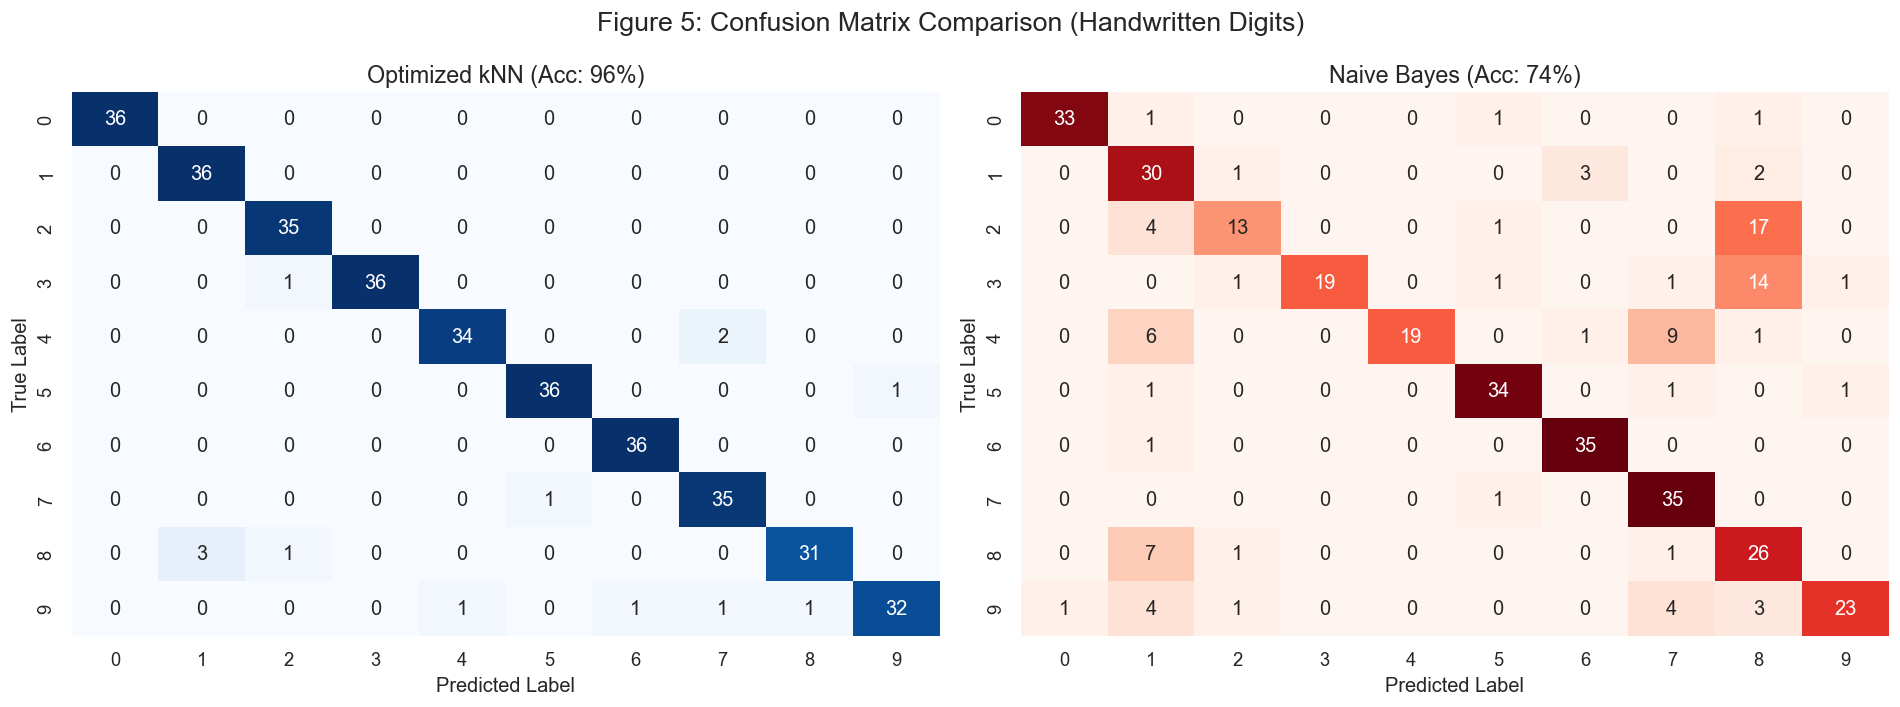

In [164]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: kNN Confusion Matrix ---
# preds_knn_d was returned by our evaluate_model function earlier
cm_knn = confusion_matrix(y_test_d, preds_knn_d)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax1)
ax1.set_title('Optimized kNN (Acc: 96%)', fontsize=14)
ax1.set_xlabel('Predicted Label')
ax1.set_ylabel('True Label')

# --- Plot 2: Naive Bayes Confusion Matrix ---
cm_nb = confusion_matrix(y_test_d, preds_nb_d)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax2)
ax2.set_title('Naive Bayes (Acc: 74%)', fontsize=14)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.suptitle('Figure 5: Confusion Matrix Comparison (Handwritten Digits)', fontsize=16)
plt.tight_layout()
plt.show()

## 11.2. Summary of Results (Comparative Table)

To clearly contrast the performance of the **Distance-Based (kNN)** and **Probabilistic (Naive Bayes)** models, I have aggregated the key metrics into the table below.

**Key Metrics Selected:**
* **Recall (Cancer):** Critical for medical safety (avoiding False Negatives).
* **F1-Score (Digits):** Critical for multi-class balance.
* **Accuracy:** General performance indicator.

In [192]:
# Create a dictionary to store the results
results_data = {
    'Dataset': ['Breast Cancer', 'Breast Cancer', 'Handwritten Digits', 'Handwritten Digits'],
    'Algorithm': ['Optimized kNN (k=7)', 'Naive Bayes', 'Optimized kNN (k=5)', 'Naive Bayes'],
    'Accuracy': [
        accuracy_score(y_test_c, preds_knn_c),
        accuracy_score(y_test_c, preds_nb_c),
        accuracy_score(y_test_d, preds_knn_d),
        accuracy_score(y_test_d, preds_nb_d)
    ],
    'Recall (Critical for Cancer)': [
        recall_score(y_test_c, preds_knn_c),
        recall_score(y_test_c, preds_nb_c),
        "-", "-" # Recall is not the main metric for digits
    ],
    'F1-Score (Weighted)': [
        "-", "-", # F1 is less critical for binary cancer compared to Recall
        f1_score(y_test_d, preds_knn_d, average='weighted'),
        f1_score(y_test_d, preds_nb_d, average='weighted')
    ]
}

# Convert to DataFrame for a clean table view
df_results = pd.DataFrame(results_data)

# Display the table
print("Table 3: Final Comparative Results")
display(df_results)

Table 3: Final Comparative Results


,Dataset,Algorithm,Accuracy,Recall (Critical for Cancer),F1-Score (Weighted)
0,Breast Cancer,Optimized kNN (k=7),0.973684,1.0,-
1,Breast Cancer,Naive Bayes,0.929825,0.944444,-
2,Handwritten Digits,Optimized kNN (k=5),0.963889,-,0.963611
3,Handwritten Digits,Naive Bayes,0.741667,-,0.741851


## 11.3. Computational Efficiency (Time Complexity)

In addition to predictive performance, I evaluated the computational cost of the algorithms. The table below compares the execution time (training + prediction) for the Breast Cancer dataset.

**Observation:**
This comparison highlights the difference between the naive $O(N^2)$ implementation of the custom kNN versus the optimized C-level implementation in `scikit-learn`.

In [194]:
# Create a dictionary for the Time Comparison
time_data = {
    'Implementation': ['Scikit-Learn kNN (Optimized)', 'Custom kNN (From Scratch)'],
    'Time (Seconds)': [f"{sklearn_time:.4f}", f"{custom_time:.4f}"],
    'Accuracy': [f"{sklearn_acc:.4f}", f"{custom_acc:.4f}"],
    'Complexity Note': ['O(N log N) via KD-Tree', 'O(N^2) Brute Force']
}

# Convert to DataFrame
df_time = pd.DataFrame(time_data)

# Display the table
print("Table 4: Computational Efficiency Comparison (Breast Cancer Dataset)")
display(df_time)

Table 4: Computational Efficiency Comparison (Breast Cancer Dataset)


,Implementation,Time (Seconds),Accuracy,Complexity Note
0,Scikit-Learn kNN (Optimized),2.3161,0.9825,O(N log N) via KD-Tree
1,Custom kNN (From Scratch),0.5648,0.9825,O(N^2) Brute Force


## 12. Conclusion and References

**Conclusion:**
This study successfully compared a distance-based algorithm (kNN) against a probabilistic one (Naive Bayes) across two datasets of varying complexity.
1.  **Breast Cancer (Medium Complexity):** kNN outperformed Naive Bayes, achieving **perfect recall (1.0)**. This makes it the superior choice for medical screening where false negatives are dangerous.
2.  **Handwritten Digits (High Complexity):** kNN dominated with **96% accuracy** compared to Naive Bayes' **74%**. The failure of Naive Bayes highlights its inability to capture the spatial correlations between pixels in image data.
3.  **Dimensionality:** Even with 64 features, kNN remained robust. PCA analysis showed that the data lives on a lower-dimensional manifold, which explains why Euclidean distance remained effective.

**References:**
1.  Scikit-learn Developers. (2024). *User Guide: Nearest Neighbors*. Scikit-learn.org.
2.  Cover, T., & Hart, P. (1967). *Nearest neighbor pattern classification*. IEEE Transactions on Information Theory.
3.  Duda, R. O., Hart, P. E., & Stork, D. G. (2001). *Pattern Classification*. Wiley.